In [1]:
import numpy as np
from scipy.signal import correlate, welch
from scipy.io import wavfile as wav
import scipy.linalg as linalg
import matplotlib.pyplot as plt
from scipy.fft import fft
from arch.unitroot import ADF, PhillipsPerron, KPSS
from scipy.interpolate import interp1d
from scipy.signal import butter, lfilter
import scipy.io.wavfile
from IPython.display import Audio
from pydub import AudioSegment

c:\Python311\Lib\site-packages\pydub\utils.py:170: RuntimeWarning: Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work
  warn("Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work", RuntimeWarning)


Evaluo si puedo usar prediccion forward para estacionario

In [74]:
def EsEstacionario(signal, alpha):
  #PhillipsPerron Test
  phpr_result = PhillipsPerron(signal)
  phpr_p_value = phpr_result.pvalue
  phpr_test_result = "Stationary" if phpr_p_value < alpha else "Not stationary"
  print("PhillipsPerron Test:", phpr_test_result)
  # Augmented Dickey-Fuller Test
  adf_result = ADF(signal)
  adf_p_value = adf_result.pvalue
  adf_test_result = "Stationary" if adf_p_value < alpha else "Not stationary"
  print("Augmented Dickey-Fuller Test:", adf_test_result)
  # Kwiatkowski-Phillips-Schmidt-Shin Test
  kpss_result = KPSS(signal, lags=-1)
  kpss_p_value = kpss_result.pvalue
  kpss_test_result = "Stationary" if kpss_p_value > alpha else "Not stationary"
  print("Kwiatkowski-Phillips-Schmidt-Shin Test:", kpss_test_result)

In [75]:
# Carga el archivo WAV original
original_audio = AudioSegment.from_file("./a.wav")

# Define la frecuencia de muestreo deseada (16 kHz en este caso)
nueva_frecuencia = 16000

# Realiza el downsampling
audio_downsampled = original_audio.set_frame_rate(nueva_frecuencia)

# Guarda el audio downsampled en un nuevo archivo
audio_downsampled.export("./a_16khz.wav", format="wav")

<_io.BufferedRandom name='./a_16khz.wav'>

In [77]:
# Carga el archivo WAV original
original_audio = AudioSegment.from_file("./sh.wav")

# Define la frecuencia de muestreo deseada (16 kHz en este caso)
nueva_frecuencia = 16000

# Realiza el downsampling
audio_downsampled = original_audio.set_frame_rate(nueva_frecuencia)

# Guarda el audio downsampled en un nuevo archivo
audio_downsampled.export("./sh_16khz.wav", format="wav")

<_io.BufferedRandom name='./sh_16khz.wav'>

In [78]:
#Valor significativo: 
alpha = 0.05
#95% de confianza

In [168]:
a_sr, signal_a = wav.read("./a_16khz.wav")
signal_a_aux = signal_a.ravel()

In [83]:
EsEstacionario(signal_a_aux/np.max(abs(signal_a)), alpha)

PhillipsPerron Test: Stationary
Augmented Dickey-Fuller Test: Stationary
Kwiatkowski-Phillips-Schmidt-Shin Test: Stationary


In [169]:
sh_sr, signal_sh = wav.read("./sh_16khz.wav")
signal_sh_aux = signal_sh.ravel()

In [84]:
EsEstacionario(signal_sh_aux/np.max(abs(signal_sh)), alpha)

PhillipsPerron Test: Stationary
Augmented Dickey-Fuller Test: Stationary
Kwiatkowski-Phillips-Schmidt-Shin Test: Stationary


va a dar estacionario porque marc me pidio que sea estable // DIO ESTACIONARIO A CASITAAA

ploteo las señales

In [171]:
signal_a = signal_a - np.mean(signal_a)
signal_a = signal_a / np.abs(np.argmax(signal_a))
signal_sh = signal_sh - np.mean(signal_sh)
signal_sh = signal_sh / np.abs(np.argmax(signal_sh))

In [ ]:
'''# Dividir las señales en canales izquierdo y derecho (si son estéreo)
if len(signal_a.shape) == 2:
    left_a, right_a = signal_a[:, 0], signal_a[:, 1]
else:
    left_a, right_a = signal_a, signal_a  # Si es mono, usar el mismo canal para ambos lados

if len(signal_sh.shape) == 2:
    left_sh, right_sh = signal_sh[:, 0], signal_sh[:, 1]
else:
    left_sh, right_sh = signal_sh, signal_sh  # Si es mono, usar el mismo canal para ambos lados'''

In [172]:
# Convertir a mono
left_a = np.mean(signal_a, axis=1)
left_sh =  np.mean(signal_sh, axis=1)

c:\Python311\Lib\site-packages\matplotlib\axes\_axes.py:7773: RuntimeWarning: divide by zero encountered in log10
  Z = 10. * np.log10(spec)


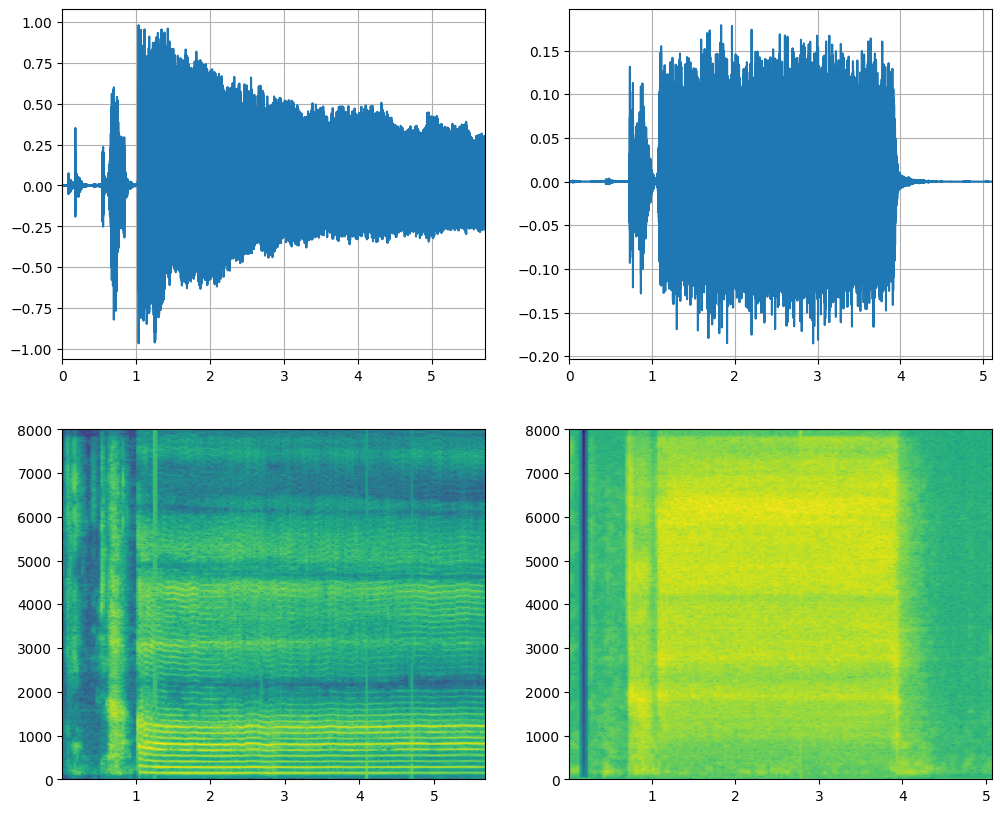

In [173]:
# Crear subgráficos
fig, axs = plt.subplots(2, 2, figsize=(12, 10))

# Plotear las señales
axs[0, 0].grid()
axs[0, 0].set_xlim(0, len(left_a) / a_sr)
axs[0, 0].plot(np.arange(len(left_a)) / a_sr, left_a)
axs[1, 0].specgram(left_a, Fs=a_sr, cmap='viridis', NFFT=1024, noverlap=512)

axs[0, 1].grid()
axs[0, 1].set_xlim(0, len(left_sh) / sh_sr)
axs[0, 1].plot(np.arange(len(left_sh)) / sh_sr, left_sh)
axs[1, 1].specgram(left_sh, Fs=sh_sr, cmap='viridis', NFFT=1024, noverlap=512)

plt.show()

In [174]:
signal_a = left_a
signal_sh = left_sh

prediccion forward

In [177]:
m_array = [i for i in range(1,1500)]
#m_array = [int(x) for x in (np.logspace(0, 4.2, num = 1000))]
N = len(signal_sh)
r = correlate(signal_sh, signal_sh, 'full')[len(signal_sh)-1:] / len(signal_sh)
Jo_sh_array = []
a0_sh_array = []
for m in m_array:
    r_forward = np.conjugate(r[1:m+1]) #esto puede estar mal, no entendi bien si es realmente esto
    a0 = linalg.solve_toeplitz(r[:m], -1*r_forward)
    jo = r[0] + np.dot(r[1:m+1], np.transpose(a0))
    Jo_sh_array.append(jo)
    a0_sh_array.append(a0)


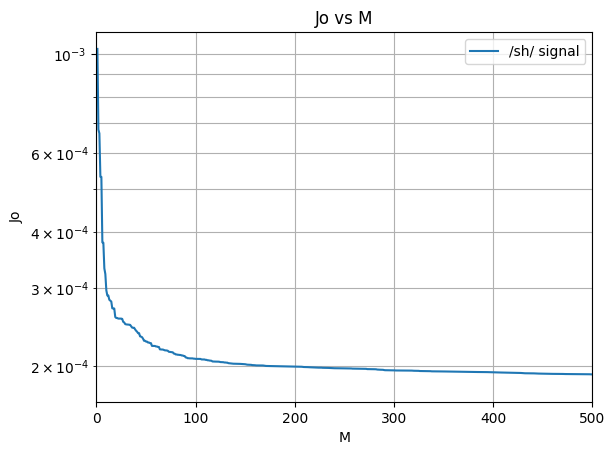

In [178]:
plt.title('Jo vs M')
plt.xlabel('M')
plt.ylabel('Jo')
plt.xlim(0,500)
plt.grid(which='both')
plt.semilogy(m_array, Jo_sh_array,label = '/sh/ signal')
plt.legend()
plt.show()

In [180]:
m_array = [i for i in range(1,2000)]
#m_array = [int(x) for x in (np.logspace(0, 4.2, num = 1000))]
N = len(signal_a)
r = correlate(signal_a, signal_a, 'full')[len(signal_a)-1:] / len(signal_a)
Jo_a_array = []
a0_a_array = []
for m in m_array:
    r_forward = np.conj(r[1:m+1]) #esto puede estar mal, no entendi bien si es realmente esto
    a0 = linalg.solve_toeplitz(r[:m], -1*r_forward)
    jo = r[0] + np.dot(r[1:m+1], np.transpose(a0))
    Jo_a_array.append(jo)
    a0_a_array.append(a0)


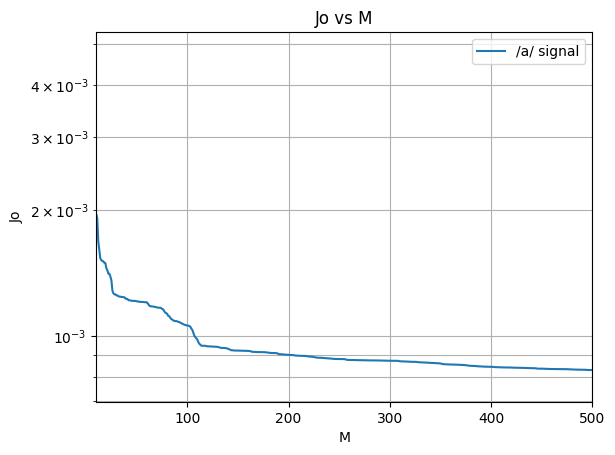

In [182]:
plt.title('Jo vs M')
plt.xlabel('M')
plt.ylabel('Jo')
plt.xlim(10,500)
plt.grid(which='both')
plt.semilogy(m_array, Jo_a_array,label = '/a/ signal')
plt.legend()
plt.show()

"investigo lo de los codos de a" 

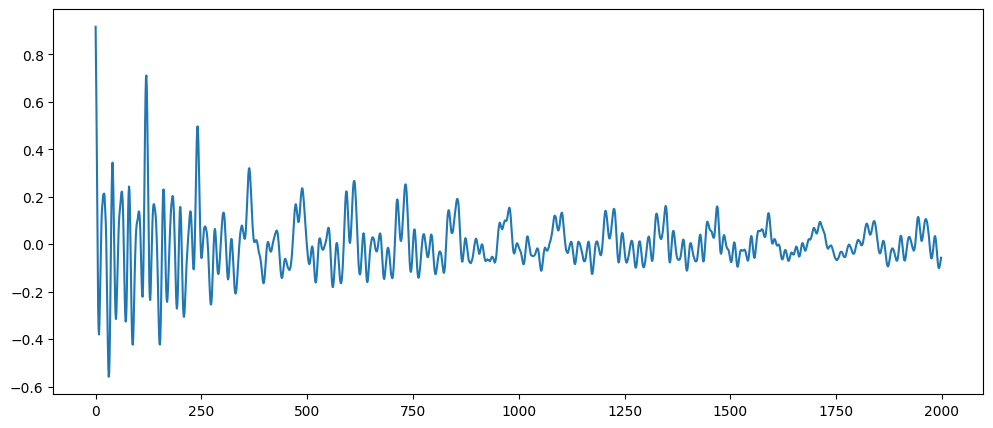

In [116]:
r = correlate(signal_a, signal_a, 'full')[len(signal_a)-1:] / len(signal_a)
r = r_forward / np.max(np.abs(r)) #si no normalizo es feo

plt.figure(figsize=(12,5))
plt.plot(np.arange(len(r)), r)
plt.show()

[]

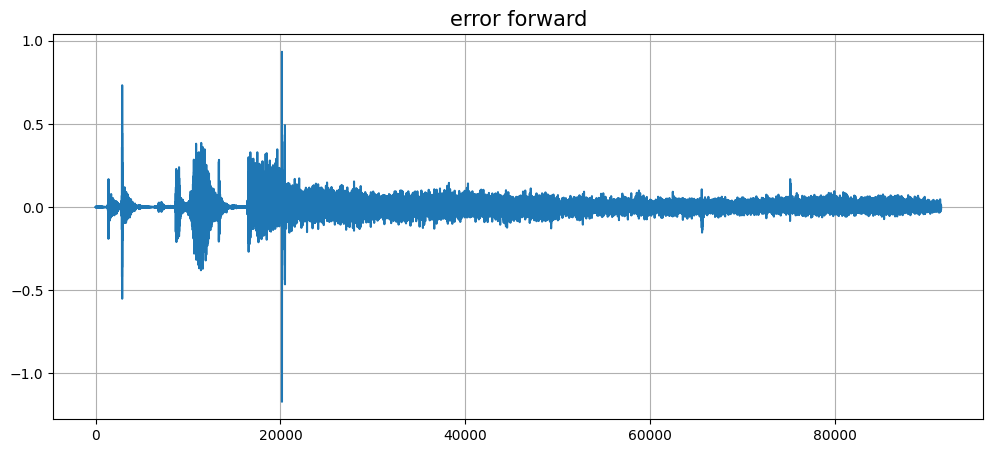

In [118]:
#a0 = linalg.solve_toeplitz(r[:m], -1*r_forward) 
a_aux = a0_a_array[200]
a_error = np.concatenate(([1], a_aux))
error_forward = np.convolve(signal_a, a_error, mode='full')[:len(signal_a)] #[len(signal_a):]
plt.figure(figsize=(12,5))
plt.title('error forward', fontsize=15)
plt.plot(error_forward)
plt.grid(which='both')
plt.plot()

Para las grabaciones del punto 1, representen la respuesta en frecuencia H(ejω)
del filtro del error de predicción ā (no el filtro predictor a) para M = 1, 2, 4, 8, 16,
32, 64. Expliquen y justifiquen los resultados obtenidos, teniendo en cuenta J(M)
y ef
(n).

In [143]:
m_array = [1, 2, 4, 8, 16, 32, 64]
a1_a = np.concatenate(([1],a0_a_array[1]))
a2_a = np.concatenate(([1],a0_a_array[2]))
a4_a = np.concatenate(([1],a0_a_array[4]))
a8_a = np.concatenate(([1],a0_a_array[8]))
a16_a = np.concatenate(([1],a0_a_array[16]))
a32_a = np.concatenate(([1],a0_a_array[32]))
a64_a = np.concatenate(([1],a0_a_array[64]))
a1_sh = np.concatenate(([1],a0_sh_array[1]))
a2_sh = np.concatenate(([1],a0_sh_array[2]))
a4_sh = np.concatenate(([1],a0_sh_array[4]))
a8_sh = np.concatenate(([1],a0_sh_array[8]))
a16_sh = np.concatenate(([1],a0_sh_array[16]))
a32_sh = np.concatenate(([1],a0_sh_array[32]))
a64_sh = np.concatenate(([1],a0_sh_array[64]))



In [122]:
print(a64_a.shape)
print(len(a64_a))

(66,)
66


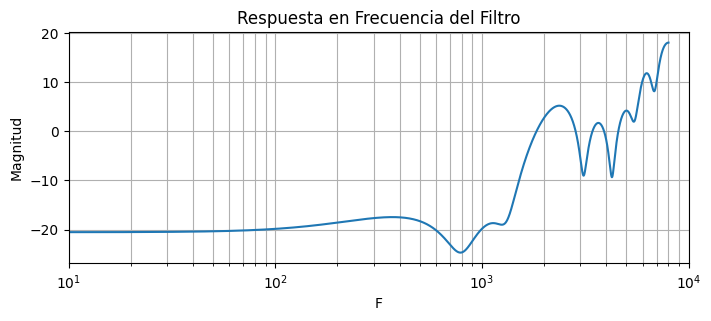

In [163]:
b = a16_a  # Coeficientes del numerador
a = [1]  # Coeficientes del denominador (ejemplo)

# Frecuencias angulares desde 0 a pi (0 a 180 grados)
omega = np.linspace(0, np.pi, num=10000)

# Calcula la respuesta en frecuencia en el dominio z usando la DFT
n = np.arange(len(b))  # Valores de n
z = np.exp(1j * omega)  # Valores de z en el círculo unitario
H = np.polyval(b, z) / np.polyval(a, z)  # Respuesta en frecuencia

# Convierte la respuesta en frecuencia al dominio de frecuencia (omega)
frequencies = omega  * a_sr * 1.0 / (2 * np.pi)

# Grafica la magnitud de la respuesta en frecuencia
plt.figure(figsize=(8, 3))
plt.semilogx(frequencies, 20 * np.log10(np.abs(H)))
plt.xlim(10,10000)
plt.title('Respuesta en Frecuencia del Filtro')
plt.xlabel('F')
plt.ylabel('Magnitud')
plt.grid(which='both')
plt.show()




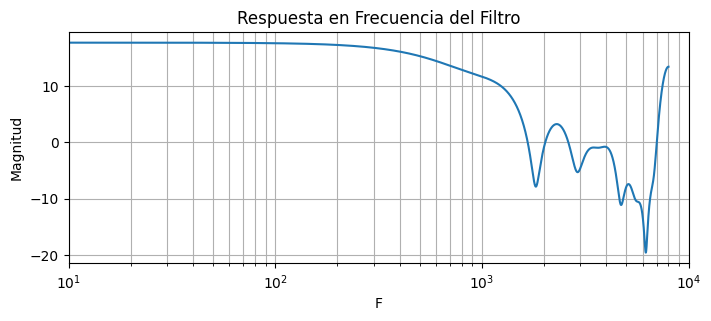

In [166]:
b = a16_sh  # Coeficientes del numerador
a = [1]  # Coeficientes del denominador (ejemplo)

# Frecuencias angulares desde 0 a pi (0 a 180 grados)
omega = np.linspace(0, np.pi, num=10000)

# Calcula la respuesta en frecuencia en el dominio z usando la DFT
n = np.arange(len(b))  # Valores de n
z = np.exp(1j * omega)  # Valores de z en el círculo unitario
H = np.polyval(b, z) / np.polyval(a, z)  # Respuesta en frecuencia

# Convierte la respuesta en frecuencia al dominio de frecuencia (omega)
frequencies = omega  * sh_sr * 1.0 / (2 * np.pi)

# Grafica la magnitud de la respuesta en frecuencia
plt.figure(figsize=(8, 3))
plt.semilogx(frequencies, 20 * np.log10(np.abs(H)))
plt.xlim(10,10000)
plt.title('Respuesta en Frecuencia del Filtro')
plt.xlabel('F')
plt.ylabel('Magnitud')
plt.grid(which='both')
plt.show()
